# Linear Buckling Analysis

versionadded v1.0.15+

Here we use the idea from this blog [Minimal Plate Buckling Example](https://portwooddigital.com/2025/05/24/minimal-plate-buckling-example/) for linear buckling analysis. 
However, opstool provides a very convenient wrapper and visualization:

In [1]:
import openseespy.opensees as ops

import opstool as opst


## Define the model

Build the model. Geometric nonlinearity needs to be considered in order to extract the stiffness matrix later.

In [2]:
# Plate dimensions
L = 50.0
h = 8.0
t = 1.0

# Material properties
E = 29000
v = 0.3

ops.wipe()
ops.model("basic", "-ndm", 3, "-ndf", 6)

ops.node(1, 0, -h / 2, 0)
ops.node(2, 0, h / 2, 0)
ops.node(3, 0, h / 2, L)
ops.node(4, 0, -h / 2, L)

c = h / 4  # Mesh size

ops.mesh("line", 1, 2, *[1, 2], 0, 6, c)
ops.mesh("line", 2, 2, *[2, 3], 0, 6, c)
ops.mesh("line", 3, 2, *[3, 4], 0, 6, c)
ops.mesh("line", 4, 2, *[4, 1], 0, 6, c)

ops.section("ElasticMembranePlateSection", 1, E, v, t)

ops.mesh("quad", 13, 4, *[4, 3, 2, 1], 0, 6, c, "ShellNLDKGT", 1)  # geometry nonlinear

ops.fixZ(0, 1, 1, 1, 0, 0, 0)  # bottom nodes, Z=0
ops.fixZ(L, 1, 1, 0, 0, 0, 0)  # top nodes, Z=L

ops.fix(1, 0, 0, 0, 1, 0, 0)

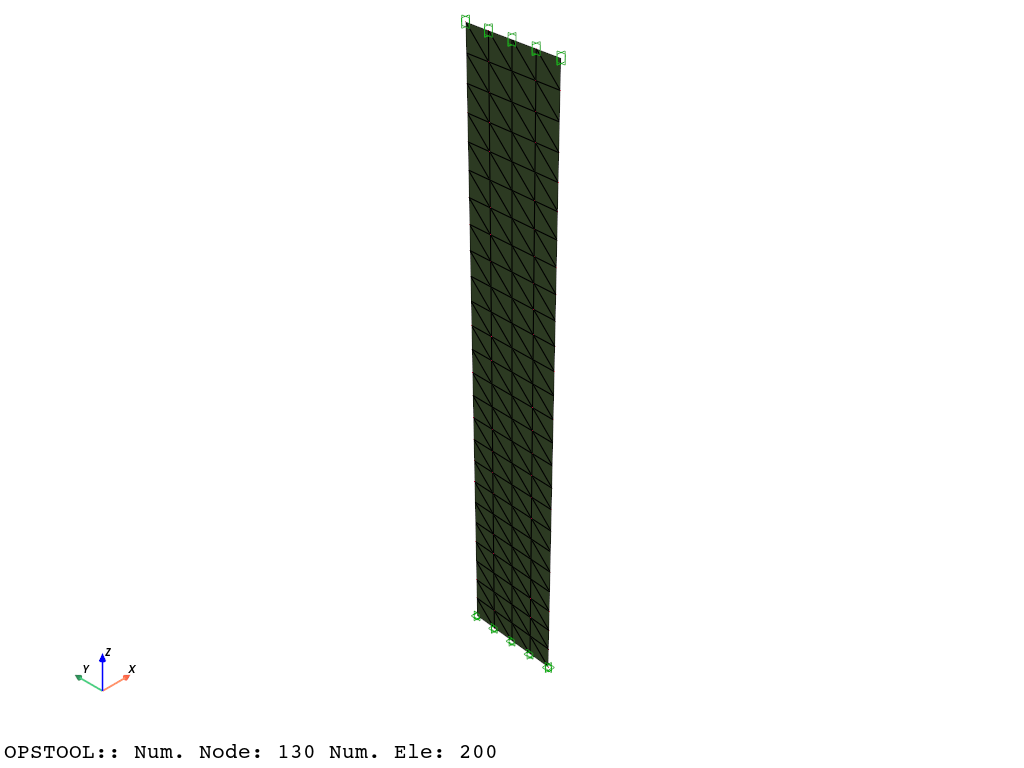

In [3]:
opst.vis.pyvista.set_plot_props(notebook=True)

fig = opst.vis.pyvista.plot_model()
fig.show(jupyter_backend="static")

## Material Stiffness Matrix

Before any load is applied, the stiffness matrix only includes the material stiffness. 

opstool provides a function ``opstool.pre.get_mck`` to obtain various matrices. 

Since ``constraints`` and ``system`` affect the dimensions of the matrices, in order to facilitate the internal allocation of node eigenvalues ​​in opstool, `"Penalty"` and `"FullGeneral"` must be used. 
At this time, the matrix dimensions are the same as the total number of degrees of freedom in the model.

In [4]:
constraints_args = ["Penalty", 1e10, 1e10]  # must be this way!!!!
system_args = ["FullGeneral"]  # must be this way!!!!
numberer_args = ["RCM"]  # can be arbitrary, but RCM is a good choice

kmat = opst.pre.get_mck("k", constraints_args=constraints_args, system_args=system_args, numberer_args=numberer_args)

## Geometric Stiffness Matrix

The ``load distribution pattern`` is very important for linear buckling analysis. 

The load multiplier obtained is the multiplier of the distribution pattern, that is, how large the load multiplier is required to cause buckling under this load distribution pattern.

In [5]:
endNodes = ops.getNodeTags("-mesh", 3)  # tag 3 = line mesh across top of plate
Pref = 1
dP = Pref / len(endNodes)

ops.timeSeries("Constant", 1)
ops.pattern("Plain", 1, 1)
for nd in endNodes:
    ops.load(nd, 0, 0, -dP, 0, 0, 0)

ops.analysis("Static", "-noWarnings")
ops.analyze(1)  # need to analyze once to get the geometric stiffness matrix

0

Get the current stiffness matrix, which is $k=k_{mat} - k_{geo}$

In [6]:
k = opst.pre.get_mck("k", constraints_args=constraints_args, system_args=system_args, numberer_args=numberer_args)

kgeo = kmat - k

## Linear buckling analysis

Solve and save buckling analysis data

In [7]:
opst.post.save_linear_buckling_data(
    kmat=kmat,
    kgeo=kgeo,
    n_modes=6,  # number of buckling modes to save
    odb_tag="linear_buckling_plate",  # tag for the output database
)

OPSTOOL ::  Linear Buckling data has been saved to .opstool.output/LinearBucklingData-linear_buckling_plate.nc!

Retrieving Buckling Analysis Data

In [8]:
eigenvalues, eigenvectors = opst.post.get_linear_buckling_data(odb_tag="linear_buckling_plate")

OPSTOOL ::  Loading Linear Buckling data from .opstool.output/LinearBucklingData-linear_buckling_plate.nc ...

In [9]:
eigenvalues.to_numpy()

array([  76.70466696,  311.01550611,  713.4311364 , 1296.96135758,
       2075.34631271, 3063.52889254])

## Visualize the buckling modes

You need to set ``mode="buckling"`` and pass in ``odbtag``. 
The other parameters are the same as for eigenvalue analysis.

OPSTOOL ::  Loading Linear Buckling data from .opstool.output/LinearBucklingData-linear_buckling_plate.nc ...

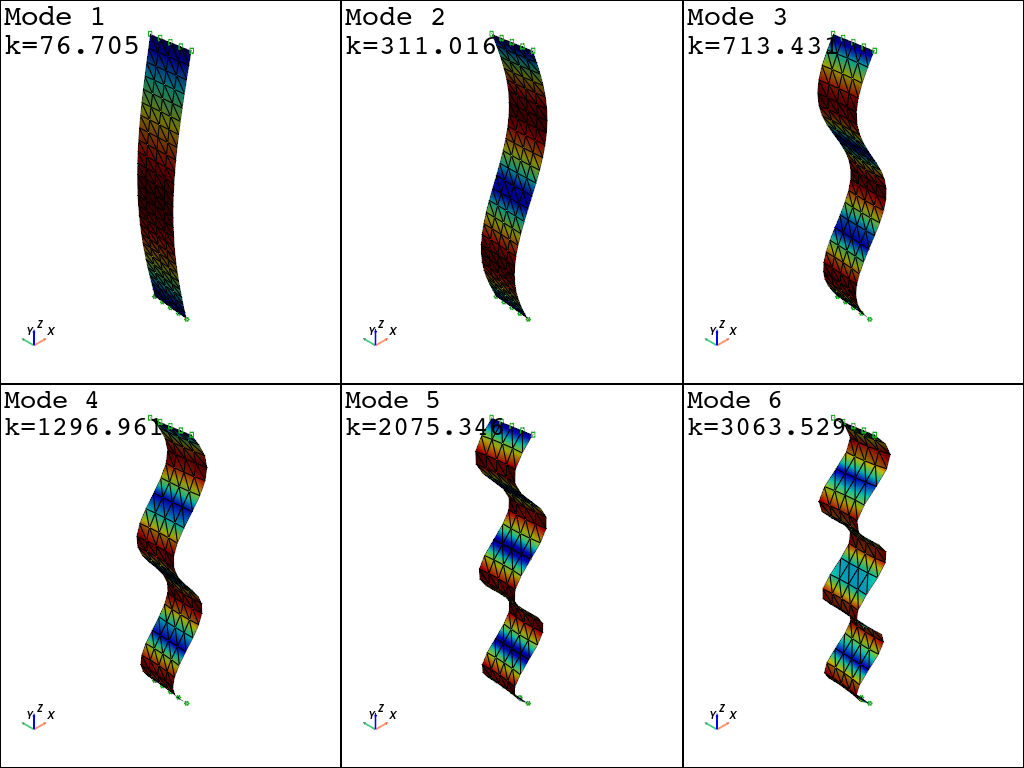

In [10]:
fig = opst.vis.pyvista.plot_eigen(
    mode="buckling", mode_tags=[1, 6], odb_tag="linear_buckling_plate", subplots=True, show_bc=True
)
fig.show(jupyter_backend="static")